# Time Series Forecasting with ARIMA Models

This notebook demonstrates how to model and forecast time series data using ARIMA-related functions (AR, MA, ARMA, ARIMA/SARIMAX) that have been added to the `gwexpy` `TimeSeries` class.

## Setup

Import the necessary libraries.

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings(
    "ignore", message=r".*force_all_finite.*", category=FutureWarning
)
warnings.filterwarnings("ignore", category=FutureWarning, module=r"sklearn\..*")
warnings.filterwarnings("ignore", category=FutureWarning, module=r"pmdarima\..*")

from gwexpy.timeseries import TimeSeries

## Creating Sample Data

To verify the effectiveness of ARIMA models, we create synthetic data that includes a trend, seasonality (periodicity), and noise.

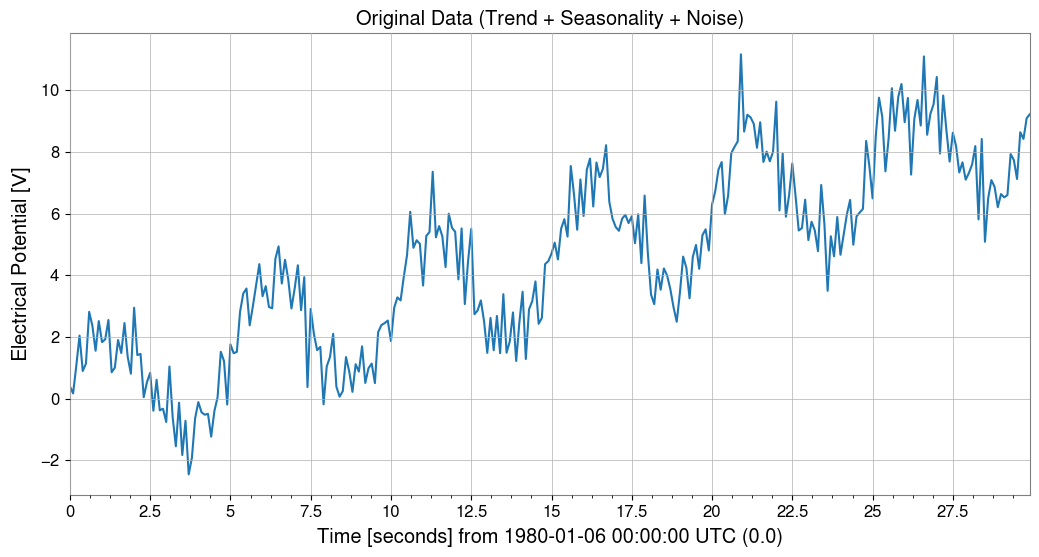

In [2]:
# Trend + Seasonality + Noise
t0 = 0
dt = 0.1
duration = 30
t = np.arange(0, duration, dt)
n_samples = len(t)

# 1. Linear Trend
trend = 0.3 * t

# 2. Periodic component (Sine)
seasonality = 2.0 * np.sin(2 * np.pi * 0.2 * t)

# 3. Noise
np.random.seed(42)
noise = np.random.normal(0, 0.8, n_samples)

data = trend + seasonality + noise

# Create TimeSeries object
ts = TimeSeries(data, t0=t0, dt=dt, unit="V", name="Sample Data")

ts.plot()
plt.title("Original Data (Trend + Seasonality + Noise)")
plt.show()

## 1. AR (AutoRegressive) Model

The AR model assumes that the current value depends on past values.
Use the `ts.ar(p)` method, where `p` is the order.

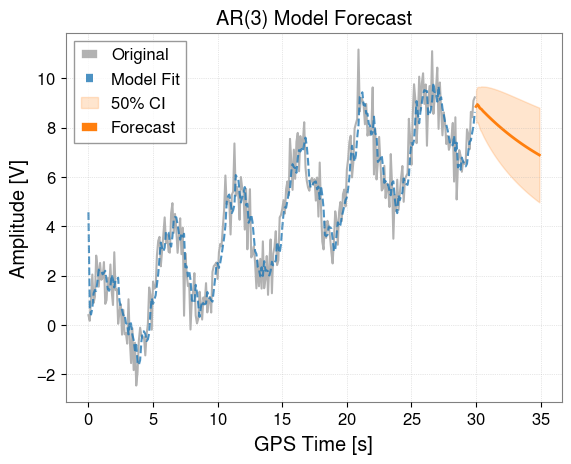

In [3]:
# Fit with order p=3
model_ar = ts.ar(p=3)

# Display model summary
# print(model_ar.summary())

# Plot results
# forecast_steps specifies how many steps to forecast into the future
model_ar.plot(forecast_steps=50, alpha=0.5)
plt.title("AR(3) Model Forecast")
plt.show()

## 2. MA (Moving Average) Model

The MA model assumes that the current value depends on past prediction errors (white noise).
Use the `ts.ma(q)` method.

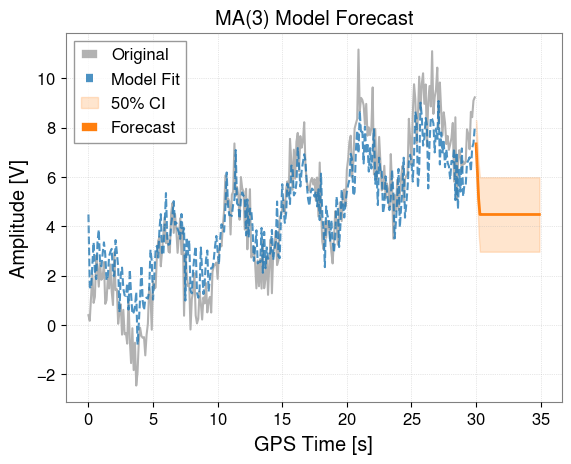

In [4]:
# Fit with order q=3
model_ma = ts.ma(q=3)

# Plot results
model_ma.plot(forecast_steps=50, alpha=0.5)
plt.title("MA(3) Model Forecast")
plt.show()

## 3. ARMA (AutoRegressive Moving Average) Model

The ARMA model combines AR and MA.
Use the `ts.arma(p, q)` method.

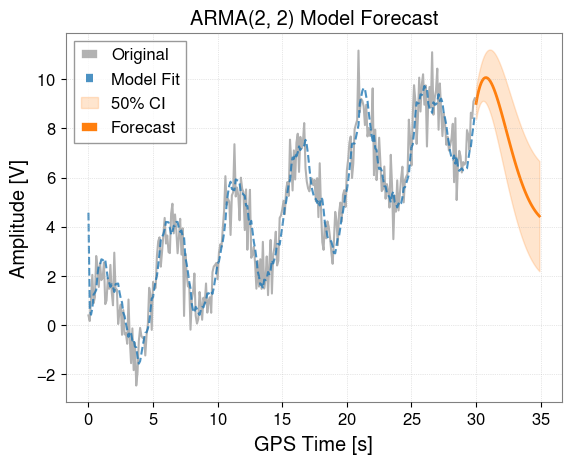

In [5]:
# Fit with p=2, q=2
model_arma = ts.arma(p=2, q=2)

model_arma.plot(forecast_steps=50, alpha=0.5)
plt.title("ARMA(2, 2) Model Forecast")
plt.show()

## 4. ARIMA / Auto-ARIMA

The ARIMA model removes non-stationarity (such as trends) by differencing, then applies the ARMA model.

Use the `ts.arima()` method.
With the `auto=True` option, the `pmdarima` library is used to automatically search for optimal parameters (p, d, q). This is the most recommended approach.

Searching for optimal ARIMA parameters... (this may take a few seconds)


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  300
Model:             SARIMAX(1, 1, 2)x(1, 0, [], 50)   Log Likelihood                -404.141
Date:                             Sun, 25 Jan 2026   AIC                            820.282
Time:                                     20:52:05   BIC                            842.485
Sample:                                          0   HQIC                           829.169
                                             - 300                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0044      0.006      0.695      0.487      -0.008       0.017
ar.L1          0.8693      

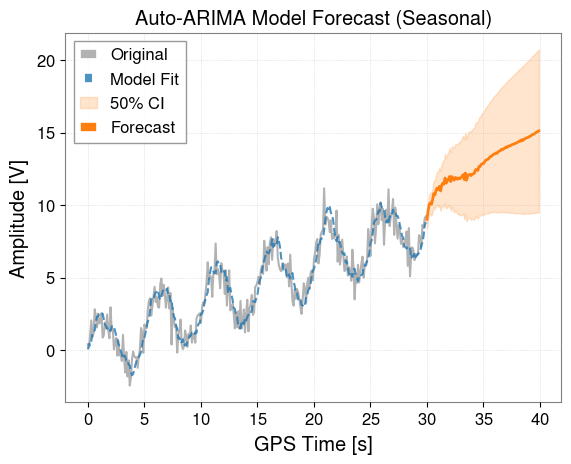

In [6]:
try:
    print("Searching for optimal ARIMA parameters... (this may take a few seconds)")

    # Seasonality can also be considered
    # m is the number of steps in a seasonal period
    model_auto = ts.arima(auto=True, auto_kwargs={"seasonal": True, "m": 50})

    # Show info of the optimal model found
    print(model_auto.summary())

    # Plot results (Forecasting for a longer period)
    ax = model_auto.plot(forecast_steps=100, alpha=0.5)
    plt.title("Auto-ARIMA Model Forecast (Seasonal)")
    plt.show()
except ImportError as e:
    print(f"Auto-ARIMA skipping: {e}")


## 5. Obtaining Forecast Data

Beyond plotting, you can directly obtain forecast values as a `TimeSeries` object using the `.forecast()` method.
This also includes confidence intervals.

In [7]:
steps = 50

# Get forecast values and confidence intervals
forecast_ts, intervals = model_auto.forecast(
    steps=steps, alpha=0.5
)  # 50% confidence interval

print("Forecast Data:")
print(forecast_ts)

print("\nConfidence Interval (Upper):")
print(intervals["upper"])

# Forecasting data can be saved or used for other analysis
# forecast_ts.write("forecast.h5")

Forecast Data:
TimeSeries([ 9.02063128,  9.6094657 , 10.04247631, 10.15366767,
            10.05259752, 10.38953478, 10.79815151, 10.7102782 ,
            11.00660841, 11.18205246, 11.08230575, 11.29883086,
            10.98339909, 11.34917016, 11.51885752, 11.45196135,
            11.87327454, 11.52379202, 11.68683767, 11.78939489,
            11.98098488, 11.63016415, 11.97773587, 11.84043006,
            11.72116502, 11.91254974, 11.88390331, 11.78617651,
            11.87744683, 11.82552359, 11.8978438 , 11.97900621,
            12.11133271, 11.76628531, 12.22002418, 11.72134893,
            11.98240157, 12.11216243, 12.11237931, 12.04095457,
            12.14350252, 12.16098484, 12.20712226, 12.45443674,
            12.45772244, 12.3928846 , 12.67001456, 12.66918777,
            12.811045  , 12.86573742]
           unit: V,
           t0: 30.0 s,
           dt: 0.1 s,
           name: Sample Data_auto_forecast,
           channel: None)

Confidence Interval (Upper):
TimeSeries([ 9

## 6. Application in Gravitational Wave Data Analysis: Noise Removal (Whitening) with ARIMA

In gravitational wave data analysis, a process called **whitening** is performed to extract burst signals or ringdown waveforms from stationary "colored noise".
By training an ARIMA model as a predictive model for background noise and subtracting the predicted values from the measured values (taking residuals), it is possible to remove noise and enhance the signal.

### Step 1: Generating Colored Noise and Injecting a Signal
First, we create colored noise with strong low-frequency components (AR(1) process), and embed a weak signal (sine-Gaussian) that is difficult to distinguish otherwise.
Note: We use "strain" as the unit, which is recognizable by Astropy.

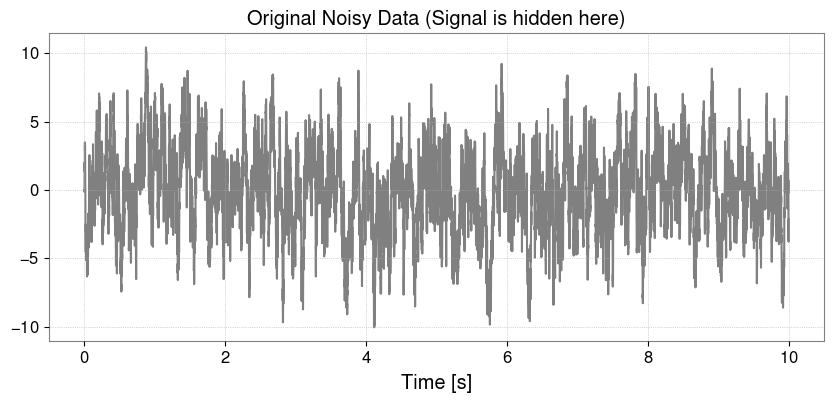

In [8]:
import matplotlib.pyplot as plt
import numpy as np

from gwexpy.timeseries import TimeSeries


def generate_mock_data(duration=10, fs=1024):
    t = np.linspace(0, duration, int(duration * fs))

    # 1. Background Noise (AR(1) process with strong autocorrelation)
    np.random.seed(42)
    white_noise = np.random.normal(0, 1, len(t))
    colored_noise = np.zeros_like(white_noise)
    for i in range(1, len(t)):
        colored_noise[i] = 0.95 * colored_noise[i - 1] + white_noise[i]

    # 2. Injected Signal (Sine-Gaussian)
    center_time = 5.0
    sig_freq = 50.0
    width = 0.1
    signal = (
        2.0
        * np.exp(-((t - center_time) ** 2) / (2 * width**2))
        * np.sin(2 * np.pi * sig_freq * t)
    )

    data = colored_noise + signal
    # Use a standard unit string that astropy/gwpy can recognize
    return TimeSeries(data, t0=0, dt=1 / fs, unit="strain", name="MockData")


ts = generate_mock_data()

plt.figure(figsize=(10, 4))
plt.plot(ts, color="gray")
plt.title("Original Noisy Data (Signal is hidden here)")
plt.xlabel("Time [s]")
plt.grid(True, linestyle=":")
plt.show()

### Step 2: Noise Modeling with ARIMA
Using `auto=True`, we search for the optimal model that expresses the autocorrelation structure of the background noise.

In [9]:
print("Searching for optimal noise model parameters...")
# We prioritize AR model for whitening, so we set max_p=5 and max_q=0.
model = ts.arima(auto=True, max_p=5, max_q=0)
print(f"Best model order: {model.res.model.order}")
print(model.summary())

Searching for optimal noise model parameters...


Best model order: (5, 1, 0)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                10240
Model:               SARIMAX(5, 1, 0)   Log Likelihood              -14694.968
Date:                Sun, 25 Jan 2026   AIC                          29403.936
Time:                        20:52:11   BIC                          29454.574
Sample:                             0   HQIC                         29421.057
                              - 10240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0003      0.010     -0.033      0.973      -0.020       0.019
ar.L1         -0.0379      0.010     -3.794      0.000      -0.057      -0.018
ar.L2         -0.0413   

### Step 3: Extracting and Visualizing Residuals
By subtracting the "stationary noise" predicted by the model, we obtain the residuals $x_r = x - \hat{x}$. This is the whitened data.

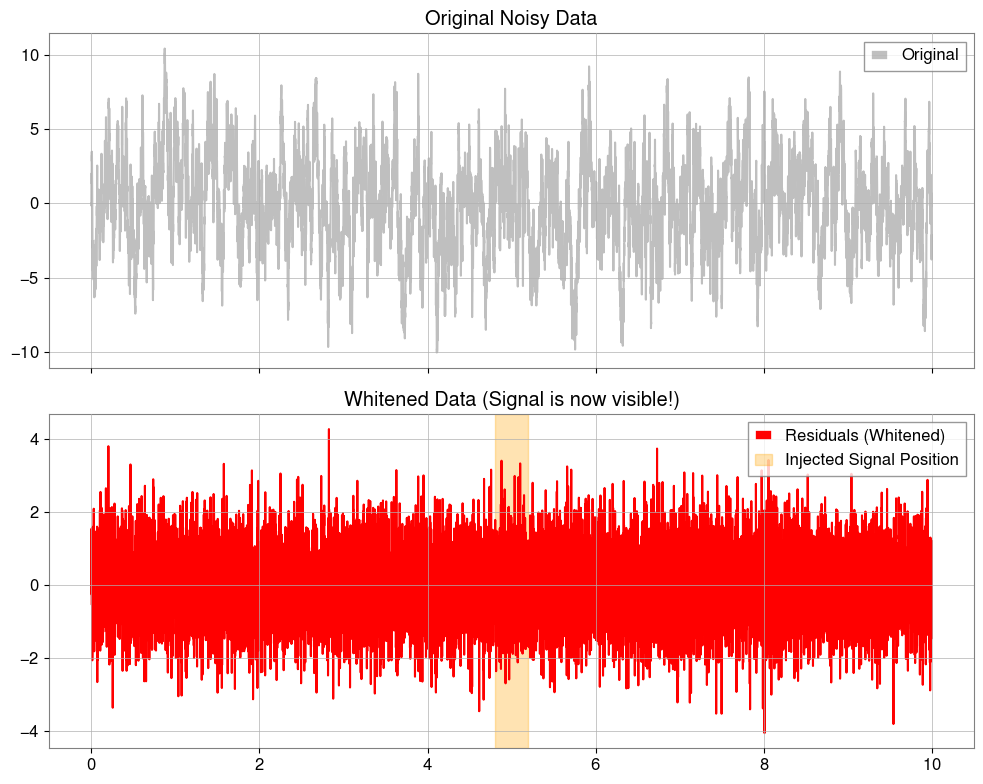

In [10]:
ts_whitened = model.residuals()
ts_whitened.name = "Whitened Data"

fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax[0].plot(ts, color="gray", alpha=0.5, label="Original")
ax[0].set_title("Original Noisy Data")
ax[0].legend(loc="upper right")

ax[1].plot(ts_whitened, color="red", label="Residuals (Whitened)")
ax[1].set_title("Whitened Data (Signal is now visible!)")
ax[1].axvspan(4.8, 5.2, color="orange", alpha=0.3, label="Injected Signal Position")
ax[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

### Step 4: Evaluation in the Frequency Domain
We calculate and compare the Power Spectral Density (PSD).

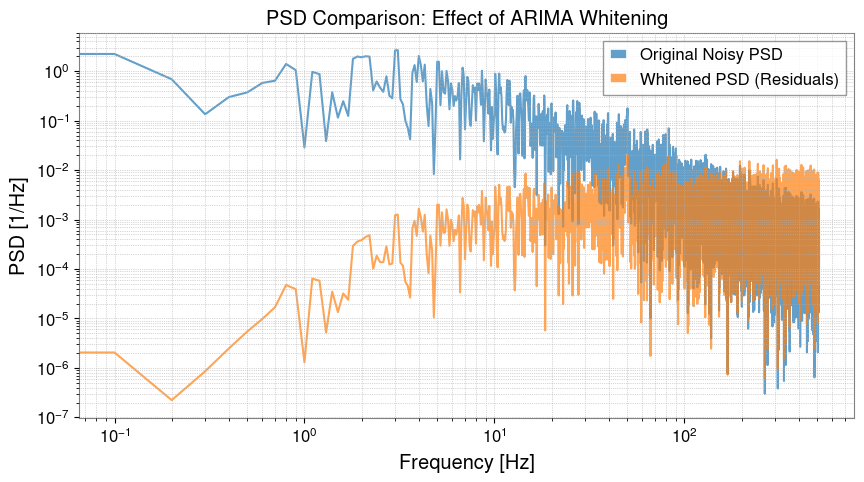

In [11]:
fft_original = ts.psd()
fft_whitened = ts_whitened.psd()

plt.figure(figsize=(10, 5))
plt.loglog(
    fft_original.frequencies.value,
    fft_original.value,
    label="Original Noisy PSD",
    alpha=0.7,
)
plt.loglog(
    fft_whitened.frequencies.value,
    fft_whitened.value,
    label="Whitened PSD (Residuals)",
    alpha=0.7,
)
plt.title("PSD Comparison: Effect of ARIMA Whitening")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [1/Hz]")
plt.legend()
plt.grid(True, which="both", linestyle=":")
plt.show()

### Summary
- Using `model.residuals()`, whitening can be easily performed without writing complex mathematical formulas.
- This technique is very powerful for searching for burst signals in gravitational wave analysis and for extracting ringdown waveforms (exponentially decaying sinusoids) immediately after events.